In [ ]:
# import libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.manifold import TSNE

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
nltk.download('punkt') 

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

!pip install distance
import distance

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from tqdm import tqdm
import os

!pip install chart_studio
#from plotly import plotly
#import plotly.offline as offline
#import plotly.graph_objs as go

import chart_studio.plotly as py
import plotly.graph_objs as go
from collections import Counter

from prettytable import PrettyTable

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 184kB 4.2MB/s 
  Created wheel for distance: filename=Distance-0.1.3-cp37-none-any.whl size=16261 sha256=e07ac41951a7c477ecb0e806b964a066a7f7cc268ac3f14772f36c441eab7217
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance


     |████████████████████████████████| 71kB 3.4MB/s 


In [ ]:
# collab drive mount
from google.colab import drive
drive.mount('/content/drive')

# loading previos feature extraction dataset
data = pd.read_csv("/content/drive/MyDrive/collab_data/Quora/feature_extraction_train.csv")

Mounted at /content/drive


In [ ]:
data.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,lenq1,lenq2,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,12,26,0.461538,2,0


# 1.0 Preprocess Text (Q1 & Q2)

**Steps to folllow:**

*   Removing HTML tags 
*   Removing Special symbols(eg: ?,./@#!*)
*   Removing URLs
*   Removing Punctuations
*   Expanding contractions(eg: $ = dollar, ₹ = rupee, ,000,000 = m, 000 = k , she's = she is , i'm = i am 
)


---



---


  **Should be done later during final text processing** 
    ( if done it may change ortitention of words in a sentence )
*   Removing Stopwords ( done later )
*   Performing Stemming


In [ ]:
STOP_WORDS = stopwords.words("english")

porter = PorterStemmer()


# pre process text data 
def preprocess(sentence):
  # lowercase
  sentence = str(sentence).lower()
  # remove html tags
  cleantext = BeautifulSoup(sentence, "lxml").text
  # remove urls
  cleantext = re.sub(r"http\S+", "", cleantext)
  # remove special characters
  cleantext = re.sub(r'[?|.|!|*|@|#|\|,|)|(|\|/|′|]', r'', cleantext)
  # expanding contractions
  cleantext = cleantext.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")
  cleantext = cleantext.replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")
  cleantext = cleantext.replace("n't", " not").replace("what's", "what is").replace("it's", "it is")
  cleantext = cleantext.replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")
  cleantext = cleantext.replace("he's", "he is").replace("she's", "she is").replace("'s", " own")
  cleantext = cleantext.replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")
  cleantext = cleantext.replace("€", " euro ").replace("'ll", " will").replace("&", "and")
  cleantext = re.sub(r"([0-9]+)000000", r"\1m", cleantext)
  cleantext = re.sub(r"([0-9]+)000", r"\1k", cleantext)


  # stemming (not used now, if used it may change words placement in a sentence)
  # should me done before applying ml algo
  '''
  words = word_tokenize(cleantext) 
  word_set = set()
  word_list = []
  for w in words:
    word_set.add(porter.stem(w))
  for x in word_set:
    word_list.append(x)

  str1 = " "
  final_str = str1.join(word_list)
  '''

  # romove stopwords ( not used now, if used analysis of sentence may miss out information)
  # should me done before applying ml algo
  '''
  words = word_tokenize(cleantext) 
  sentence_words = [word for word in words if word not in STOP_WORDS]
  final_sentence = " ".join(sentence_words)
  '''

  return cleantext


In [ ]:
print(preprocess("hi <h3> hello world's most precious 1000 island? 23$ </h> program, programs, programer, programing, programers <br> ?ok, i'm nice/ https://ice.com good biscuit"))

hi  hello world own most precious 1k island 23 dollar   program programs programer programing programers  ok i am nice  good biscuit


# 2.0 Advanace Feature Extraction ( NLP & fuzzy )

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [ ]:
def get_token_features(Q1,Q2):

  # save number upto 4 decimal place
  SAFE_DIV = 0.0001 

  # list with 0.0 values size of 10 
  token_features = [0.0]*10


  # pass Q1 and Q2 through basic preprocess functioin
  Q1_preprocess = preprocess(Q1)
  Q2_preprocess = preprocess(Q2)


  # converting sentence into tokens
  Q1_tokens = Q1_preprocess.split()
  Q2_tokens = Q2_preprocess.split()
  
  # if not token founds
  if len(Q1_tokens)==0 or len(Q2_tokens)==0 :
    return token_features

  # Words ( Tokens without stopwords, we can aslo say stopwords removed )
  Q1_words = set(word for word in Q1_tokens if word not in STOP_WORDS)
  Q2_words = set(word for word in Q2_tokens if word not in STOP_WORDS)

  # Stopwords in Q1 and Q2
  Q1_stopwords = set(sw for sw in Q1_tokens if sw in STOP_WORDS)
  Q2_stopwords = set(sw for sw in Q2_tokens if sw in STOP_WORDS)


  # total common words between Q1 and Q2 ( non stopwords )
  common_word_count = len(Q1_words.intersection(Q2_words))

  # total common stopwords between Q1 and Q2 
  common_stop_word_count = len(Q1_stopwords.intersection(Q2_stopwords))

  # total common token between Q1 and Q2 (token = words + stopwords)
  common_token_count = len(set(Q1_tokens).intersection(set(Q2_tokens)))
  


  #############################################################


  # cwc_min: Ratio of common_word_count to min lenghth of word count of Q1 and Q2
  cwc_min = (common_word_count)/ (min(len(Q1_words), len(Q2_words)) + SAFE_DIV)

  # cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
  cwc_max = (common_word_count)/ (max(len(Q1_words), len(Q2_words)) + SAFE_DIV)

  # csc_min : Ratio of common_stop_word_count to min lenghth of stop count of Q1 and Q2
  csc_min = (common_stop_word_count)/ (min(len(Q1_stopwords), len(Q2_stopwords)) + SAFE_DIV)

  # csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
  csc_max = (common_stop_word_count)/ (max(len(Q1_stopwords), len(Q2_stopwords)) + SAFE_DIV)

  # ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
  ctc_min = (common_token_count)/ (min(len(Q1_tokens), len(Q2_tokens)) + SAFE_DIV)

  # ctc_max: Ratio of common_token_count to max lenghth of token count of Q1 and Q2
  ctc_max = (common_token_count)/ (max(len(Q1_tokens), len(Q2_tokens)) + SAFE_DIV)

  # first_word_eq : Check if First word of both questions is equal or not
  first_word_eq = int(Q1_tokens[0] == Q2_tokens[0])

  # last_word_eq: Check if last word of both questions is equal or not
  last_word_eq = int(Q1_tokens[0] == Q2_tokens[0])

  #abs_len_diff : Abs. length difference 
  abs_len_diff = abs(len(Q1_tokens) - len(Q2_tokens))

  #mean_len : Average Token Length of both Questions
  mean_len = (len(Q1_tokens) + len(Q2_tokens))/2

  return cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, first_word_eq, last_word_eq, abs_len_diff, mean_len





In [ ]:
# funtion to return lowest common subsrting ration
# NOTE : distance is a python library 
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

In [ ]:
Q1_ = "What is the step by step guide to invest in share market in india?"
Q2_ = "What is the step by step guide to invest in share market?"

print("----- THIS IS ONLY TEST ------ \n")

Q1_preprocess = preprocess(Q1_)
Q2_preprocess = preprocess(Q2_)
print("-"*40, "Preprocess data", "-"*40)
print(Q1_preprocess)
print(Q2_preprocess)

print("-"*40, "all 10 feature data ", "-"*40)
get_token_features(Q1_preprocess, Q2_preprocess )

print("----- THIS IS ONLY TEST ------")

----- THIS IS ONLY TEST ------ 

---------------------------------------- Preprocess data ----------------------------------------
what is the step by step guide to invest in share market in india
what is the step by step guide to invest in share market
---------------------------------------- all 10 feature data  ----------------------------------------
----- THIS IS ONLY TEST ------


In [ ]:
print(get_longest_substr_ratio(Q1_, Q2_))

0.9655172413793104


In [ ]:
# if any null values are there , fill with blank string
nan_rows = data[data.isnull().any(1)]
print(nan_rows)
data = data.fillna('')
nan_rows = data[data.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2  ... word_share freq_q1+q2  freq_q1-q2
105780  105780  174363  174364  ...        0.0          4           0
201841  201841  303951  174364  ...        0.0          3           1
363362  363362  493340  493341  ...        0.0          2           0

[3 rows x 17 columns]
Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate, freq_qid1, freq_qid2, lenq1, lenq2, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2]
Index: []


In [ ]:
li = ['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'first_word_eq', 'last_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_partial_ratio', 'fuzz_ratio']
lo = ['cwc_min_value', 'cwc_max_value', 'csc_min_value', 'csc_max_value', 'ctc_min_value', 'ctc_max_value', 'first_word_eq_value', 'last_word_eq_value', 'abs_len_diff_value', 'mean_len_value', 'token_set_ratio_value', 'token_sort_ratio_value', 'fuzz_partial_ratio_value', 'fuzz_ratio_value' ]
print(len(li))
print(len(lo))

14
14


In [ ]:
# time consuming 
'''
data["preprocess_question1"] = data["question1"].fillna("").apply(preprocess)
data["preprocess_question2"] = data["question2"].fillna("").apply(preprocess)
'''

'\ndata["preprocess_question1"] = data["question1"].fillna("").apply(preprocess)\ndata["preprocess_question2"] = data["question2"].fillna("").apply(preprocess)\n'

In [ ]:
# passing arguments, calculating and adding return data into the existing dataframe 

Q1 = data['question1'].values.tolist()
Q2 = data['question2'].values.tolist()

  
cwc_min = [] 
cwc_max = []
csc_min = []
csc_max = []
ctc_min = []
ctc_max = [] 
first_word_eq = [] 
last_word_eq = [] 
abs_len_diff = [] 
mean_len = []



for i in tqdm(range(0,len(Q1))):
  Question1 = Q1[i]
  Question2 = Q2[i]

  cwc_min_value, cwc_max_value, csc_min_value, csc_max_value, ctc_min_value, ctc_max_value, first_word_eq_value, last_word_eq_value, abs_len_diff_value, mean_len_value  = get_token_features(Question1, Question2)

  cwc_min.append(cwc_min_value) 
  cwc_max.append(cwc_max_value)
  csc_min.append(csc_min_value)
  csc_max.append(csc_max_value)
  ctc_min.append(ctc_min_value)
  ctc_max.append(ctc_max_value) 
  first_word_eq.append(first_word_eq_value) 
  last_word_eq.append(last_word_eq_value) 
  abs_len_diff.append(abs_len_diff_value) 
  mean_len.append(mean_len_value)

  


print("Adding new columns to the data set..... \n")
# adding to the database
data['cwc_min'] = cwc_min
data['cwc_max'] = cwc_max
data['csc_min'] = csc_min
data['csc_max'] = csc_max
data['ctc_min'] = ctc_min
data['ctc_max'] = ctc_max
data['first_word_eq'] = first_word_eq
data['last_word_eq'] = last_word_eq
data['abs_len_diff'] = abs_len_diff
data['mean_len'] = mean_len


# show new data frame 
print("New data frame is ready ! ")

100%|██████████| 404290/404290 [04:06<00:00, 1638.29it/s]


Adding new columns to the data set..... 

New data frame is ready ! 


In [ ]:
data.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,lenq1,lenq2,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq,abs_len_diff,mean_len
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,12,26,0.461538,2,0,0.99998,0.833319,0.999983,0.999983,0.916659,0.785709,1.0,1.0,2.0,13.0


In [ ]:
# calculation and adding lowest common substring ratio into dataframe
longest_substr_ratio = []

for i in tqdm(range(0, len(Q1))):
  Question1 = Q1[0]
  Question2 = Q2[0]
  longest_substr_ratio.append(get_longest_substr_ratio(Question1, Question2))

# adding into database
data['longest_substr_ratio'] = longest_substr_ratio

print("New dataframe is ready !")

100%|██████████| 404290/404290 [04:16<00:00, 1574.38it/s]

New dataframe is ready !


In [ ]:
data.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,lenq1,lenq2,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq,abs_len_diff,mean_len,longest_substr_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,12,26,0.461538,2,0,0.99998,0.833319,0.999983,0.999983,0.916659,0.785709,1.0,1.0,2.0,13.0,0.965517


In [ ]:
# saving the dataset into new dataset
data.to_csv("/content/drive/MyDrive/collab_data/Quora/advance_feature_extraction_train(2).csv", index=False)

# 3.0 Analysis of extracted features

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/collab_data/Quora/advance_feature_extraction_train(2).csv")
data.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,lenq1,lenq2,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,first_word_eq,last_word_eq,abs_len_diff,mean_len,longest_substr_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,12,26,0.461538,2,0,0.99998,0.833319,0.999983,0.999983,0.916659,0.785709,1.0,1.0,2.0,13.0,0.965517


In [ ]:
# seperate is_dupliacte into two dataframe 
df_duplicate = data[data['is_duplicate'] == 1]
dfp_nonduplicate = data[data['is_duplicate'] == 0]


In [ ]:
# most occur words in is_dupliacte

d1 = df_duplicate['question1'].values
d2 = df_duplicate['question2'].values

dupliacted_question_stack_q1 = " ".join(d1)
dupliacted_question_stack_q2 = " ".join(d2)

dupliacted_question_stack_final = dupliacted_question_stack_q1 + dupliacted_question_stack_q2

STOP_WORDS = stopwords.words("english")
stopwords = set(STOP_WORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")

Word Cloud for Duplicate Question pairs


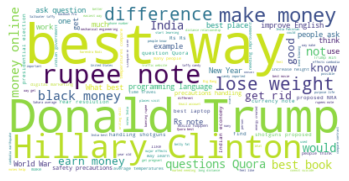

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud

wc = WordCloud(background_color="white", max_words=len(dupliacted_question_stack_final), stopwords=stopwords)
wc.generate(dupliacted_question_stack_final)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
dfp_nonduplicate['question1'].astype(str)
dfp_nonduplicate['question2'].astype(str)

# most occur words in is_not_depliacte
nd1 = dfp_nonduplicate['question1'].values
nd2 = dfp_nonduplicate['question2'].values


space = " "
nondupliacted_q1 = " ".join(nd1)
nondupliacted_q2 = " ".join(nd2)

nondupliacted_question_stack_final = nondupliacted_q1 + nondupliacted_q2



Word Cloud for non-Duplicate Question pairs:


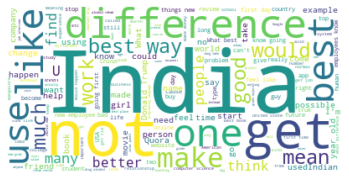

In [ ]:
wc = WordCloud(background_color="white", max_words=len(nondupliacted_question_stack_final),stopwords=stopwords)
# generate word cloud
wc.generate(nondupliacted_question_stack_final)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

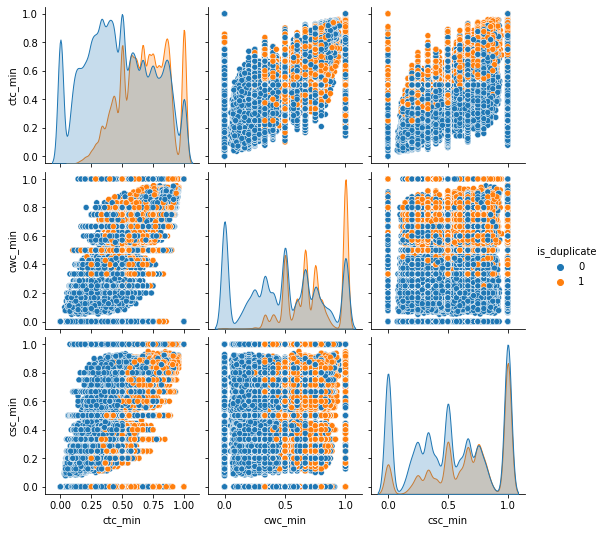

In [ ]:
n = data.shape[0]
sns.pairplot(data[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min'])
plt.show()

__PDF diagonal charts are showing minor differnece between two classes__

In [ ]:
# Using TSNE for Dimentionality reduction for 10 Features(Generated after cleaning the data) to 2 dimention

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# taking 5000 datapoiunts
dfp_subsampled = data[0:9000]

X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

# TSNE parameters
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)




[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9000 samples in 0.025s...
[t-SNE] Computed neighbors for 9000 samples in 0.606s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9000
[t-SNE] Computed conditional probabilities for sample 2000 / 9000
[t-SNE] Computed conditional probabilities for sample 3000 / 9000
[t-SNE] Computed conditional probabilities for sample 4000 / 9000
[t-SNE] Computed conditional probabilities for sample 5000 / 9000
[t-SNE] Computed conditional probabilities for sample 6000 / 9000
[t-SNE] Computed conditional probabilities for sample 7000 / 9000
[t-SNE] Computed conditional probabilities for sample 8000 / 9000
[t-SNE] Computed conditional probabilities for sample 9000 / 9000
[t-SNE] Mean sigma: 0.030481
[t-SNE] Computed conditional probabilities in 0.593s
[t-SNE] Iteration 50: error = 91.5892868, gradient norm = 0.0293450 (50 iterations in 5.111s)
[t-SNE] Iteration 100: error = 75.1020355, gradient norm = 0.0049548 (50 iterations in 3.

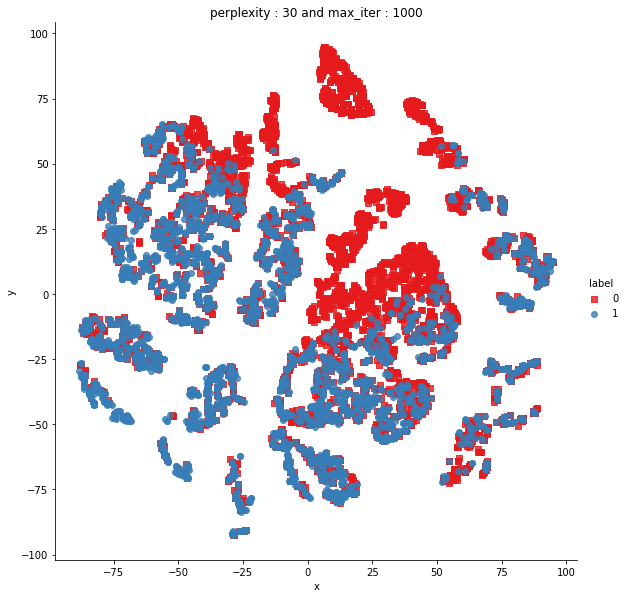

In [ ]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [ ]:
#PCA 

# taking 9000 datapoiunts
dfp_subsampled = data[0:9000]

X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

# TSNE parameters
tsne2d = TSNE(
    n_components=2,
    init='pca', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9000 samples in 0.023s...
[t-SNE] Computed neighbors for 9000 samples in 0.606s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9000
[t-SNE] Computed conditional probabilities for sample 2000 / 9000
[t-SNE] Computed conditional probabilities for sample 3000 / 9000
[t-SNE] Computed conditional probabilities for sample 4000 / 9000
[t-SNE] Computed conditional probabilities for sample 5000 / 9000
[t-SNE] Computed conditional probabilities for sample 6000 / 9000
[t-SNE] Computed conditional probabilities for sample 7000 / 9000
[t-SNE] Computed conditional probabilities for sample 8000 / 9000
[t-SNE] Computed conditional probabilities for sample 9000 / 9000
[t-SNE] Mean sigma: 0.030481
[t-SNE] Computed conditional probabilities in 0.605s
[t-SNE] Iteration 50: error = 74.7706833, gradient norm = 0.0050354 (50 iterations in 3.651s)
[t-SNE] Iteration 100: error = 71.4302368, gradient norm = 0.0027438 (50 iterations in 3.

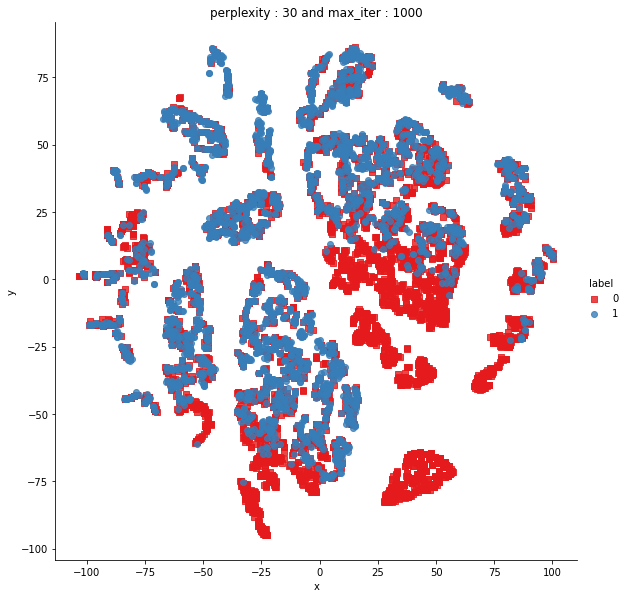

In [ ]:
# PCA PLOT

df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [ ]:
from sklearn import decomposition
X_pca = decomposition.PCA(n_components=2).fit_transform(X)

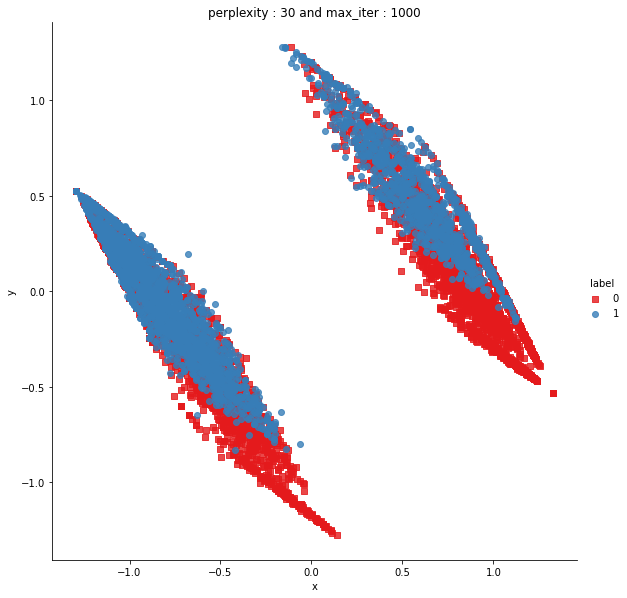

In [ ]:
# PCA PLOT

df = pd.DataFrame({'x':X_pca[:,0], 'y':X_pca[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()